## Prediction of drug effects with Matrix factorization using JAX (v2)

In [ ]:
!pip install iterative-stratification

In [ ]:
import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import tqdm.notebook as tq
from matplotlib import pyplot as plt
import seaborn as sns
#import jax.tools.colab_tpu

print(jax.__version__)
#jax.tools.colab_tpu.setup_tpu()
jax.devices()

use_gex = False

0.3.1


In [ ]:
!git clone https://github.com/saezlab/Macau_project_1

# log(IC50) values are the target values we want to predict
df_logIC50 = pd.read_csv('Macau_project_1/DATA/IC50')
df_logIC50 = df_logIC50.rename(columns={df_logIC50.columns[0]: 'drug'}).set_index('drug')
df_logIC50.columns = df_logIC50.columns.astype(int)
df_logIC50.columns.name = 'cell'
df_logIC50 = df_logIC50.dropna(how='all', axis=0).dropna(how='all', axis=1)
df_logIC50 = df_logIC50.groupby(level=0).mean() # merge duplicates
df_logIC50

Cloning into 'Macau_project_1'...
remote: Enumerating objects: 639, done.
remote: Total 639 (delta 0), reused 0 (delta 0), pack-reused 639
Receiving objects: 100% (639/639), 22.29 MiB | 12.92 MiB/s, done.
Resolving deltas: 100% (208/208), done.


cell,906794,753531,753532,753535,1290724,1240121,1290725,1240122,753538,910916,...,1330981,908120,1303911,1240224,905943,1298144,930301,1480367,1299069,1298218
drug,,,,,,,,,,,,,,,,,,,,,
(5Z)-7-Oxozeaenol,0.658335,NaN,-1.325406,0.939506,1.821348,0.206012,NaN,-0.088335,-1.141660,-0.134729,...,NaN,1.092113,NaN,NaN,1.850057,-1.281399,2.072898,-1.218180,0.790413,-0.254128
17-AAG,-1.063684,-2.991489,-2.984041,-1.296775,-1.671236,-2.654259,NaN,-2.175841,-0.315078,-1.503114,...,NaN,NaN,NaN,NaN,-3.838040,-2.640476,NaN,-2.605768,-2.800907,-3.478281
5-Fluorouracil,4.494420,NaN,6.743152,3.536679,5.927311,3.816903,5.088776,3.925727,3.214750,0.812453,...,NaN,6.360370,3.518497,4.764271,5.366326,5.669954,4.664973,4.577209,4.964509,5.619640
681640,3.267664,0.721941,2.670563,0.383930,-0.275749,NaN,NaN,-0.110991,0.802898,2.643872,...,NaN,NaN,NaN,NaN,2.307994,3.624146,NaN,NaN,3.388692,2.153330
A-443654,-0.824600,-1.453398,0.934030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.004121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZM-447439,2.923008,1.681763,2.215170,1.773549,2.645239,0.821525,NaN,1.643008,0.840058,2.106408,...,NaN,NaN,NaN,NaN,1.163537,3.116433,NaN,NaN,2.467468,2.984484
ZSTK474,1.970227,-0.040417,4.550096,0.188311,1.966542,1.031812,2.200663,2.235504,3.002436,1.686198,...,-2.979928,-0.364515,-0.515054,1.119114,3.409242,3.344700,3.168154,1.357647,2.390701,0.910767
"Zibotentan, ZD4054",5.504864,5.322678,6.208079,5.550987,6.008991,5.786668,5.659521,5.930262,5.096935,5.535655,...,NaN,5.956038,6.434422,5.395583,5.314176,5.847765,5.790843,5.610767,5.677819,5.789839


In [ ]:
# Drug features (targets)
df_drug_features = pd.read_csv('Macau_project_1/DATA/target')
df_drug_features = df_drug_features.rename(columns={df_drug_features.columns[0]: 'drug'}).set_index('drug')
df_drug_features = df_drug_features.groupby(level=0).first() # merge dups
df_drug_features = df_drug_features.loc[df_logIC50.index] # align with target
df_drug_features

,EGFR,MTORC1,PDGFR,KIT,VEGFR,FLT3,RET,CSF1R,MET,Proteasome,...,ESR1,EGLN1,RNA helicase A,Induces reactive oxygen species,NAMPT,TRAIL receptor agonist,L3MBTL3,DOT1L,DNA alkylating agent,NAE
drug,,,,,,,,,,,,,,,,,,,,,
(5Z)-7-Oxozeaenol,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17-AAG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5-Fluorouracil,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
681640,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A-443654,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZM-447439,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZSTK474,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Zibotentan, ZD4054",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Cell features
df_cell_features = pd.read_csv('Macau_project_1/DATA/progeny11')
df_cell_features = df_cell_features.rename(columns={df_cell_features.columns[0]: 'cell'}).set_index('cell')
df_cell_features = df_cell_features.loc[df_logIC50.columns.astype(int)] # align with cols in target data
df_cell_features = df_cell_features.add_prefix("PROGENY_").reset_index().rename(columns={'index':'cell'}).set_index('cell')
df_cell_features


,PROGENY_EGFR,PROGENY_Hypoxia,PROGENY_JAK.STAT,PROGENY_MAPK,PROGENY_NFkB,PROGENY_PI3K,PROGENY_TGFb,PROGENY_TNFa,PROGENY_Trail,PROGENY_VEGF,PROGENY_p53
cell,,,,,,,,,,,
906794,-0.970208,1.251282,0.538888,-1.849428,-0.369537,-0.104723,1.309720,-0.112547,-0.435198,1.384981,2.308153
753531,0.310146,0.754342,1.809670,-0.917795,1.701543,-0.753145,0.656895,1.693629,0.109413,1.127102,1.334895
753532,1.156948,1.498917,0.480790,0.388330,2.206393,-0.619267,2.154506,1.374202,0.147149,1.550934,0.914401
753535,1.157429,0.187924,2.268787,0.663885,2.395687,0.822931,1.271232,2.031291,0.273588,1.944516,1.508138
1290724,0.521418,1.006215,0.494420,0.304439,-0.161835,1.053723,1.261212,-0.563360,0.409082,1.320365,-0.195466
...,...,...,...,...,...,...,...,...,...,...,...
1298144,0.710910,0.575314,1.001989,-0.143929,1.204961,0.387551,0.928647,1.100022,0.015480,1.067804,1.219865
930301,0.710910,0.575314,1.001989,-0.143929,1.204961,0.387551,0.928647,1.100022,0.015480,1.067804,1.219865
1480367,0.710910,0.575314,1.001989,-0.143929,1.204961,0.387551,0.928647,1.100022,0.015480,1.067804,1.219865


In [ ]:
d_sample = df_logIC50.sample(frac=0.1, replace=False).index
c_sample = df_logIC50.T.sample(frac=0.1, replace=False).index
df_logIC50.loc[df_logIC50.index.difference(d_sample), df_logIC50.columns.difference(c_sample)]

cell,683665,683667,684055,684057,684059,684062,684072,684681,687448,687452,...,1524417,1524419,1659817,1659818,1659819,1659823,1660034,1660035,1660036,1674021
drug,,,,,,,,,,,,,,,,,,,,,
(5Z)-7-Oxozeaenol,-0.079227,NaN,1.526998,1.322207,1.342432,1.644847,1.753982,3.165157,1.094425,1.627017,...,1.625093,1.505419,0.291543,NaN,NaN,3.686514,-0.428419,5.784463,1.327741,0.424120
17-AAG,0.545906,0.180038,-0.513753,0.499729,0.798295,2.880443,0.401494,-1.824267,NaN,-2.822076,...,0.291047,0.149608,-0.425579,1.614435,0.029645,NaN,0.583745,0.476749,0.483880,-1.443928
5-Fluorouracil,0.145949,3.772202,3.740453,1.937160,0.615320,5.195855,2.639578,5.789331,5.971730,3.167624,...,5.311633,3.567791,3.177967,NaN,NaN,3.554433,1.294644,1.894609,1.546883,3.542535
681640,1.439772,1.993984,1.758212,0.829353,1.063181,2.609804,2.321131,3.588909,NaN,1.065646,...,2.167814,NaN,2.071141,2.596906,0.248699,NaN,3.063118,4.023680,4.184764,2.266766
A-443654,0.233667,NaN,0.543842,1.701759,0.763081,3.217858,-1.580335,2.183944,1.821707,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZM-447439,0.752087,1.522715,-0.755294,0.142937,-0.090504,4.092735,0.896470,3.689527,NaN,0.558216,...,NaN,4.055760,3.230736,2.585167,-0.332288,NaN,0.944849,3.184110,1.128063,2.980523
ZSTK474,-2.355524,0.746917,0.221963,-1.944276,-2.685910,-1.598293,0.127354,1.039487,0.620634,0.226990,...,0.478233,-0.597841,1.097406,NaN,NaN,0.173130,0.339938,2.309926,-1.635625,1.663871
"Zibotentan, ZD4054",5.046538,5.715174,5.523189,5.790380,4.480724,5.607439,5.393096,6.301953,6.612724,5.219610,...,5.919625,5.726756,4.982380,NaN,NaN,6.355159,5.391672,5.761657,6.466271,5.839159


In [ ]:
# Cell features
try:
  df_cell_features = pd.read_csv('progeny_top60_5kperm.csv')
  df_cell_features['sample'] = df_cell_features['sample'].str.replace('DATA.','')
  df_cell_features = df_cell_features.loc[~df_cell_features['sample'].str.contains('.', regex=False),:]
  df_cell_features['sample'] = df_cell_features['sample'].astype(int)
  df_cell_features = df_cell_features.set_index('sample')
  common = df_cell_features.index.intersection(df_logIC50.columns.astype(int))
  df_cell_features = df_cell_features.loc[common] # align with cols in target data
  df_cell_features = df_cell_features.add_prefix("PROGENY_").reset_index().rename(columns={'index':'cell'}).set_index('cell')
  df_logIC50 = df_logIC50.loc[:, common]
except:
  print("Progeny missing, using default")

df_cell_features

Progeny missing, using default


,PROGENY_EGFR,PROGENY_Hypoxia,PROGENY_JAK.STAT,PROGENY_MAPK,PROGENY_NFkB,PROGENY_PI3K,PROGENY_TGFb,PROGENY_TNFa,PROGENY_Trail,PROGENY_VEGF,PROGENY_p53
cell,,,,,,,,,,,
906794,-0.970208,1.251282,0.538888,-1.849428,-0.369537,-0.104723,1.309720,-0.112547,-0.435198,1.384981,2.308153
753531,0.310146,0.754342,1.809670,-0.917795,1.701543,-0.753145,0.656895,1.693629,0.109413,1.127102,1.334895
753532,1.156948,1.498917,0.480790,0.388330,2.206393,-0.619267,2.154506,1.374202,0.147149,1.550934,0.914401
753535,1.157429,0.187924,2.268787,0.663885,2.395687,0.822931,1.271232,2.031291,0.273588,1.944516,1.508138
1290724,0.521418,1.006215,0.494420,0.304439,-0.161835,1.053723,1.261212,-0.563360,0.409082,1.320365,-0.195466
...,...,...,...,...,...,...,...,...,...,...,...
1298144,0.710910,0.575314,1.001989,-0.143929,1.204961,0.387551,0.928647,1.100022,0.015480,1.067804,1.219865
930301,0.710910,0.575314,1.001989,-0.143929,1.204961,0.387551,0.928647,1.100022,0.015480,1.067804,1.219865
1480367,0.710910,0.575314,1.001989,-0.143929,1.204961,0.387551,0.928647,1.100022,0.015480,1.067804,1.219865


In [ ]:
df_basal_gex = pd.read_csv("https://www.cancerrxgene.org/gdsc1000/GDSC1000_WebResources/Data/preprocessed/Cell_line_RMA_proc_basalExp.txt.zip", sep='\t')
df_basal_gex

,GENE_SYMBOLS,GENE_title,DATA.906826,DATA.687983,DATA.910927,DATA.1240138,DATA.1240139,DATA.906792,DATA.910688,DATA.1240135,...,DATA.753584,DATA.907044,DATA.998184,DATA.908145,DATA.1659787,DATA.1298157,DATA.1480372,DATA.1298533,DATA.930299,DATA.905954.1
0,TSPAN6,tetraspanin 6 [Source:HGNC Symbol;Acc:11858],7.632023,7.548671,8.712338,7.797142,7.729268,7.074533,3.285198,6.961606,...,7.105637,3.236503,3.038892,8.373223,6.932178,8.441628,8.422922,8.089255,3.112333,7.153127
1,TNMD,tenomodulin [Source:HGNC Symbol;Acc:17757],2.964585,2.777716,2.643508,2.817923,2.957739,2.889677,2.828203,2.874751,...,2.798847,2.745137,2.976406,2.852552,2.622630,2.639276,2.879890,2.521169,2.870468,2.834285
2,DPM1,dolichyl-phosphate mannosyltransferase polypep...,10.379553,11.807341,9.880733,9.883471,10.418840,9.773987,10.264385,10.205931,...,10.486486,10.442951,10.311962,10.454830,10.418475,11.463742,10.557777,10.792750,9.873902,10.788218
3,SCYL3,SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...,3.614794,4.066887,3.956230,4.063701,4.341500,4.270903,5.968168,3.715033,...,3.696835,4.624013,4.348524,3.858121,3.947561,4.425849,3.550390,4.443337,4.266828,4.100493
4,C1orf112,chromosome 1 open reading frame 112 [Source:HG...,3.380681,3.732485,3.236620,3.558414,3.840373,3.815055,3.011867,3.268449,...,3.726833,3.947744,3.806584,3.196988,3.814831,4.384732,4.247189,3.071359,3.230197,3.435795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17732,NaN,hsa-mir-5195 [Source:miRBase;Acc:MI0018174],2.852537,2.776771,2.685307,3.436412,2.951270,3.233383,3.810246,2.792116,...,2.699663,5.190438,3.253381,3.000088,2.846830,2.959009,2.974475,2.903894,2.857956,3.033662
17733,POLRMTP1,polymerase (RNA) mitochondrial (DNA directed) ...,3.130696,3.260982,3.176239,3.074432,3.213545,3.382112,3.200106,2.829053,...,2.773728,2.988250,3.514337,3.254306,3.139208,3.007502,3.088841,2.847505,2.832840,2.817057
17734,UBL5P2,ubiquitin-like 5 pseudogene 2 [Source:HGNC Sym...,9.986616,9.002814,9.113243,9.958284,9.938978,8.714820,9.396484,9.779745,...,9.593772,9.506062,9.945730,9.890244,10.018968,9.332193,10.742651,8.544696,9.900550,9.071943
17735,TBC1D3P5,"TBC1 domain family, member 3 pseudogene 5 [Sou...",3.073724,3.000182,2.916274,3.256500,3.396126,3.497439,3.193505,3.254539,...,3.407260,3.256900,3.189972,3.155584,3.357660,3.435411,3.317945,3.174515,3.243563,3.324517


In [ ]:
# Use gene expression
df_basal_gex = df_basal_gex.drop('GENE_title', axis=1).dropna().set_index('GENE_SYMBOLS').T
df_basal_gex.index = df_basal_gex.index.str.replace('DATA.','')
df_basal_gex = df_basal_gex.loc[~df_basal_gex.index.str.contains('.', regex=False),:]
df_basal_gex.index = df_basal_gex.index.astype(int)
common = df_basal_gex.index.intersection(df_logIC50.columns.astype(int))
df_basal_gex = df_basal_gex.loc[common]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
if use_gex:
  df_basal_gex = (df_basal_gex - df_basal_gex.mean(axis=0))/(df_basal_gex.std(axis=0)*100)
  df_logIC50 = df_logIC50.loc[:,common]
  df_cell_features = df_cell_features.loc[df_logIC50.columns]
  df_cell_features = df_basal_gex
  print("Using GEX as cell features")
df_cell_features.shape, df_logIC50.shape

((990, 11), (256, 990))

In [ ]:
df_cell_features

,PROGENY_EGFR,PROGENY_Hypoxia,PROGENY_JAK.STAT,PROGENY_MAPK,PROGENY_NFkB,PROGENY_PI3K,PROGENY_TGFb,PROGENY_TNFa,PROGENY_Trail,PROGENY_VEGF,PROGENY_p53
cell,,,,,,,,,,,
906794,-0.970208,1.251282,0.538888,-1.849428,-0.369537,-0.104723,1.309720,-0.112547,-0.435198,1.384981,2.308153
753531,0.310146,0.754342,1.809670,-0.917795,1.701543,-0.753145,0.656895,1.693629,0.109413,1.127102,1.334895
753532,1.156948,1.498917,0.480790,0.388330,2.206393,-0.619267,2.154506,1.374202,0.147149,1.550934,0.914401
753535,1.157429,0.187924,2.268787,0.663885,2.395687,0.822931,1.271232,2.031291,0.273588,1.944516,1.508138
1290724,0.521418,1.006215,0.494420,0.304439,-0.161835,1.053723,1.261212,-0.563360,0.409082,1.320365,-0.195466
...,...,...,...,...,...,...,...,...,...,...,...
1298144,0.710910,0.575314,1.001989,-0.143929,1.204961,0.387551,0.928647,1.100022,0.015480,1.067804,1.219865
930301,0.710910,0.575314,1.001989,-0.143929,1.204961,0.387551,0.928647,1.100022,0.015480,1.067804,1.219865
1480367,0.710910,0.575314,1.001989,-0.143929,1.204961,0.387551,0.928647,1.100022,0.015480,1.067804,1.219865


In [ ]:
df_tissue = pd.read_csv('Macau_project_1/DATA/tissue_label_gdsc_ID').iloc[:,1:]
df_tissue.CosmicID = df_tissue.CosmicID.astype(int)
df_tissue = df_tissue.set_index('CosmicID')
df_tissue

,tissue
CosmicID,
906800,leukemia
687452,Bladder
1287381,lung_NSCLC
924100,prostate
910924,stomach
...,...
998206,lymphoma
1330945,leukemia
1298355,lung_SCLC


In [ ]:
def initialize_weights(data, row_features=None, col_features=None, k=10):
  if row_features is not None:
    LD = np.random.normal(size=(k, row_features.shape[1]))
  else:
    LD = np.random.normal(size=(k, data.shape[0]))
  if col_features is not None:
    LC = np.random.normal(size=(k, col_features.shape[1]))
  else:
    LC = np.random.normal(size=(k, data.shape[1]))
  ld_bias = jnp.zeros((k, 1))
  lc_bias = jnp.zeros((k, 1))
  mu = 0.0
  return [LD, LC, ld_bias, lc_bias, mu]

@jax.jit
def mf(params):
  LD, LC, ld_bias, lc_bias, mu = params
  Dt = jnp.transpose(jnp.add(LD, ld_bias))
  C = jnp.add(LC, lc_bias)
  return jnp.dot(Dt, C) + mu

@jax.jit
def mf_with_row_features(params, row_features):
  LD, LC, ld_bias, lc_bias, mu = params
  D = jnp.add(jnp.dot(LD, jnp.transpose(row_features)), ld_bias)
  Dt = jnp.transpose(D)
  C = jnp.add(LC, lc_bias)
  return jnp.dot(Dt, C) + mu

@jax.jit
def mf_with_col_features(params, col_features):
  LD, LC, ld_bias, lc_bias, mu = params
  Dt = jnp.transpose(jnp.add(LD, ld_bias))
  C = jnp.add(jnp.dot(LC, jnp.transpose(col_features)), lc_bias)
  return jnp.dot(Dt, C) + mu

@jax.jit
def mf_with_features(params, row_features, col_features):
  LD, LC, ld_bias, lc_bias, mu = params
  Dt = jnp.transpose(jnp.add(jnp.dot(LD, jnp.transpose(row_features)), ld_bias))
  C = jnp.add(jnp.dot(LC, jnp.transpose(col_features)), lc_bias)
  return jnp.dot(Dt, C) + mu


# Examples using different features and factorizations
row_features = df_drug_features.to_numpy()
col_features = df_cell_features.to_numpy()

params = initialize_weights(df_logIC50)
print(mf(params).shape)

params = initialize_weights(df_logIC50, row_features=row_features)
print(mf_with_row_features(params, row_features).shape)

params = initialize_weights(df_logIC50, col_features=col_features)
print(mf_with_col_features(params, col_features).shape)

params = initialize_weights(df_logIC50, row_features=row_features, col_features=col_features)
print(mf_with_features(params, row_features, col_features).shape)

(256, 990)
(256, 990)
(256, 990)
(256, 990)


In [ ]:
# Implementation of MSE loss ignoring NaN values
@jax.jit
def loss_mse(X, X_hat):
  # Count the number of valid values in the matrix
  is_nan = jnp.isnan(X)
  n = jnp.sum(~is_nan)
  # Replace NaNs with 0s. It does not affect the loss
  # as we're going to compute the average ignoring 0s
  Xf = jnp.nan_to_num(X, nan=0.)
  # Put 0s on NaN positions
  X_hat_f = jnp.where(is_nan, 0., X_hat)
  # Sum of squared residuals
  sq = jnp.power(Xf - X_hat_f, 2)
  # Average using non missing entries
  return jnp.sum(sq) / n

# Loss between the IC50 matrix target values and a random prediction
loss_mse(df_logIC50.to_numpy(), mf_with_features(params, row_features, col_features))

DeviceArray(231.02551, dtype=float32)

## Factorizing with gradient descent

In [ ]:
# Now let's define the loss with respect the parameters. This is the
# function we need to differentiate. Note that jax.jit supports if/else
# condition autodiff
@jax.jit
def loss_mf(params, X, row_features=None, col_features=None, reg=0.0):
  if row_features == None and col_features == None:
    X_hat = mf(params)
  elif row_features != None and col_features == None:
    X_hat = mf_with_row_features(params, row_features)
  elif col_features != None and row_features == None:
    X_hat = mf_with_col_features(params, col_features)
  else:
    X_hat = mf_with_features(params, row_features, col_features)
  # Add regularization for latent matrices
  l2_ld = jnp.sum(jnp.power(params[0], 2))
  l2_lc = jnp.sum(jnp.power(params[1], 2))
  return loss_mse(X, X_hat) + reg*(l2_ld + l2_lc)

# Now with a loss function, we can take the derivative with autodiff of the
# loss with respect the parameters. By default, jax.grad computes the derivatime
# with respect the first argument
params = initialize_weights(df_logIC50, row_features=row_features)
dloss = jax.grad(loss_mf)
dloss(params, df_logIC50.to_numpy(), row_features=row_features)

[DeviceArray([[ 2.8372966e-02, -2.0151261e-02,  1.5749527e-02, ...,
                4.0699309e-03,  3.1841693e-03, -1.0091120e-02],
              [ 4.3559566e-02,  6.4233989e-03,  5.4719426e-02, ...,
               -8.8615092e-03,  2.1338989e-03,  1.0509849e-02],
              [-2.5299147e-02, -3.2997556e-02,  6.5373229e-03, ...,
                7.2643728e-05, -7.6922816e-03, -2.5416982e-06],
              ...,
              [ 6.0716830e-04,  5.8596916e-02, -2.3083743e-02, ...,
                1.1602480e-02,  5.1060072e-03, -9.0610320e-03],
              [-6.2863678e-02, -1.7752413e-02, -2.0591712e-02, ...,
                9.4770705e-03, -1.9402979e-03,  2.8328272e-03],
              [ 3.9679345e-02,  1.9681754e-02, -5.4932252e-02, ...,
               -8.0203069e-03, -3.3843191e-04,  9.2575746e-03]],            dtype=float32),
 DeviceArray([[-0.00738767, -0.00280782, -0.00517628, ...,  0.00078751,
               -0.00327507,  0.00730042],
              [ 0.00043693, -0.00714787, -0.006

In [ ]:
# We can do a plain gradient descent to learn the matrices. The update
# function applies one step of gradient descent
def update(params, X, lr=0.1, loss=loss_mf, loss_options=dict()):
  loss_value, grads = jax.value_and_grad(loss)(params, X, **loss_options)
  # Decrease each variable by lr * dloss/dparam
  updated_params = [param - lr * grad for grad, param in zip(grads, params)]
  return loss_value, updated_params

# Gradient descent loop
def gd(params, X, epochs=1000, step_fn=update, options=dict(lr=0.1), loss_options=dict()):
  steps = tq.tqdm(range(epochs))
  for step in steps:
    loss_value, params = step_fn(params, df_logIC50.to_numpy(), **options,
                                 loss_options=loss_options)
    steps.set_postfix({'loss': np.round(loss_value, 4)})
  return params

params = initialize_weights(df_logIC50)
#params = gd(params, df_logIC50.to_numpy(), options={'lr': 0.1}, loss_options={'reg': 1e-2})
params = gd(params, df_logIC50.to_numpy())
loss_mf(params, df_logIC50.to_numpy())

  0%|          | 0/1000 [00:00<?, ?it/s]

DeviceArray(4.906442, dtype=float32)

In [ ]:
# Compare the speed of a jitted version. We need to wrap
# the update as we cannot dynamically pass a different loss function
# as an optional argument to a compiled function
@jax.jit
def update_mf(params, X, lr=0.1, loss_options=dict()):
  return update(params, X, lr=lr, loss_options=loss_options)

params = initialize_weights(df_logIC50)
params = gd(params, df_logIC50.to_numpy(), step_fn=update_mf)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
params = initialize_weights(df_logIC50)
params = gd(params, df_logIC50.to_numpy(), step_fn=update_mf,
            options={'lr': 0.05}, epochs=5000, loss_options={'reg': 1e-5})
params[-1]

  0%|          | 0/5000 [00:00<?, ?it/s]

DeviceArray(2.254265, dtype=float32, weak_type=True)

In [ ]:
# Note that JAX includes some custom optimizers, which converge faster than
# plain gradient descent
from jax.example_libraries import optimizers

# Initialize params and optimizer
params = initialize_weights(df_logIC50)

def optimize(X, params, opt=optimizers.adam(0.1), loss_fn=loss_mf,
             loss_options=dict(), epochs=1000):
  opt_state = opt.init_fn(params)
  steps = tq.tqdm(range(epochs))
  for step in steps:
    value, grads = jax.value_and_grad(loss_fn)(opt.params_fn(opt_state), X, **loss_options)
    opt_state = opt.update_fn(step, grads, opt_state)
    steps.set_postfix({'loss': np.round(value, 4)})
  return opt.params_fn(opt_state)
  #X = df_logIC50.to_numpy()

[LD, LC, ld_bias, lc_bias, mu] = optimize(df_logIC50.to_numpy(), params)


NameError: ignored

In [ ]:
mu

DeviceArray(0.8050077, dtype=float32)

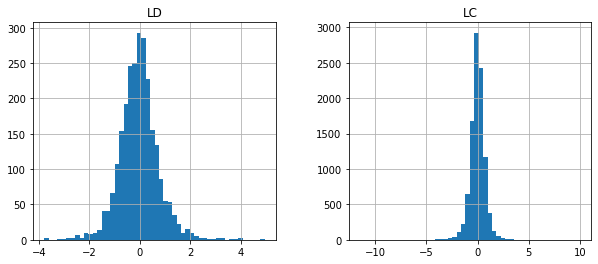

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4));
pd.DataFrame({'LD': LD.flatten()}).hist(bins=50,ax=ax[0]);
pd.DataFrame({'LC': LC.flatten()}).hist(bins=50,ax=ax[1]);

In [ ]:
pd.DataFrame({'ld_bias': ld_bias.flatten(), 'lc_bias': lc_bias.flatten()})

,ld_bias,lc_bias
0,-0.500428,-0.818941
1,-0.412448,-0.079239
2,0.109156,0.807270
3,0.012522,0.096579
4,-0.127795,-0.743283
5,-0.052245,0.108042
6,0.027900,-0.085436
7,-0.030401,0.201635
8,-0.090174,-0.571585
9,-0.171146,-0.185194


## Factorization with side information

In [ ]:
params = initialize_weights(df_logIC50, row_features=row_features, col_features=col_features)
loss_opts = {'row_features': row_features,
             'col_features': col_features,
             'reg': 1e-6}
params = optimize(df_logIC50.to_numpy(), params, epochs=500,
                  opt=optimizers.adam(0.10), loss_options=loss_opts)
[LD, LC, ld_bias, lc_bias, mu] = params

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
[LD, LC, ld_bias, lc_bias, mu] = params

In [ ]:
# Interaction matrix between drug targets and pathways
df_interaction = pd.DataFrame(jnp.dot(jnp.transpose(LD), LC), index=df_drug_features.columns, columns=df_cell_features.columns).astype(float)
df_interaction

,PROGENY_EGFR,PROGENY_Hypoxia,PROGENY_JAK.STAT,PROGENY_MAPK,PROGENY_NFkB,PROGENY_PI3K,PROGENY_TGFb,PROGENY_TNFa,PROGENY_Trail,PROGENY_VEGF,PROGENY_p53
EGFR,-0.216577,0.028611,-0.043919,0.148301,0.335951,-0.044977,-0.122480,-0.360118,0.086536,0.027399,-0.213195
MTORC1,0.094343,-0.041546,-0.044601,-0.211042,-0.137284,0.054311,-0.094644,-0.038644,-0.046584,0.001982,0.343552
PDGFR,-0.039837,-0.092979,-0.019481,-0.232971,0.185197,0.114313,-0.220969,-0.151905,-0.094623,-0.033935,-0.013108
KIT,-0.049897,0.045549,-0.005191,0.115636,0.060654,-0.055477,0.064629,-0.105257,0.042473,0.014508,-0.031170
VEGFR,0.282194,0.056562,0.021276,-0.158965,-0.014892,-0.077436,0.049050,0.065243,-0.087068,0.004852,-0.142847
...,...,...,...,...,...,...,...,...,...,...,...
TRAIL receptor agonist,-0.084099,0.023077,-0.063249,-0.133727,0.158740,0.030386,-0.053425,-0.259046,0.079905,0.015438,-0.056795
L3MBTL3,-0.027617,-0.000973,-0.006930,-0.044504,0.142331,-0.010815,-0.076458,-0.165727,-0.003543,0.000571,-0.043282
DOT1L,-0.048909,0.009066,-0.026727,-0.043549,0.131039,0.015910,-0.084114,-0.169357,0.007754,0.006432,-0.066923
DNA alkylating agent,-0.019689,-0.012052,-0.007007,-0.036776,0.166741,0.006236,-0.060475,-0.176556,-0.074354,-0.015029,-0.019368


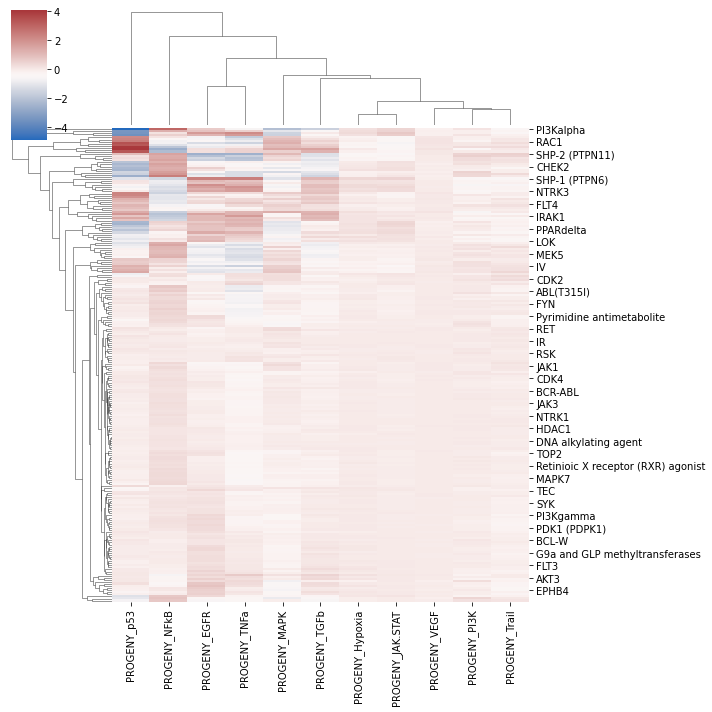

In [ ]:
sns.clustermap(df_interaction, cmap="vlag")

In [ ]:
df_interaction.loc['MEK2']

PROGENY_EGFR       -0.345411
PROGENY_Hypoxia    -0.079283
PROGENY_JAK.STAT   -0.012600
PROGENY_MAPK       -0.903411
PROGENY_NFkB        0.837997
PROGENY_PI3K        0.456603
PROGENY_TGFb       -0.541953
PROGENY_TNFa       -0.382880
PROGENY_Trail       0.071414
PROGENY_VEGF       -0.094602
PROGENY_p53        -1.007824
Name: MEK2, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


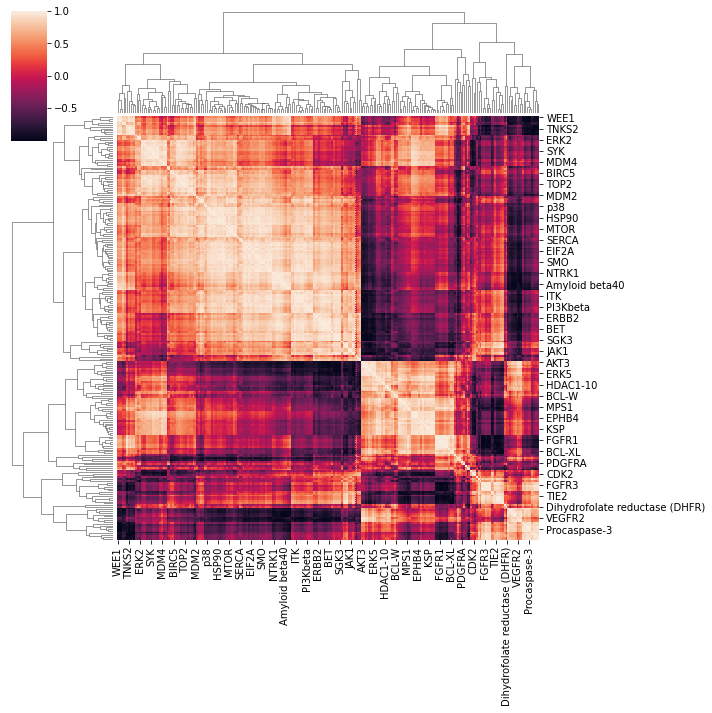

In [ ]:
df_drug_target_corr = df_interaction.T.corr()
# Cluster based on functional similarity of drug targets
sns.clustermap(df_drug_target_corr);

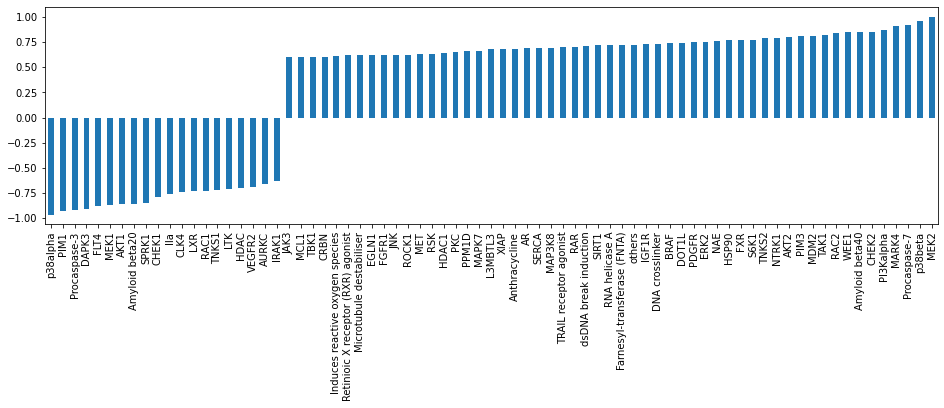

In [ ]:
# Show targets that are functionally similar to others
fig, ax = plt.subplots(figsize=(16, 4));
egfr = df_drug_target_corr['MEK2']
egfr[egfr.abs()>0.6].sort_values().plot.bar(ax=ax);

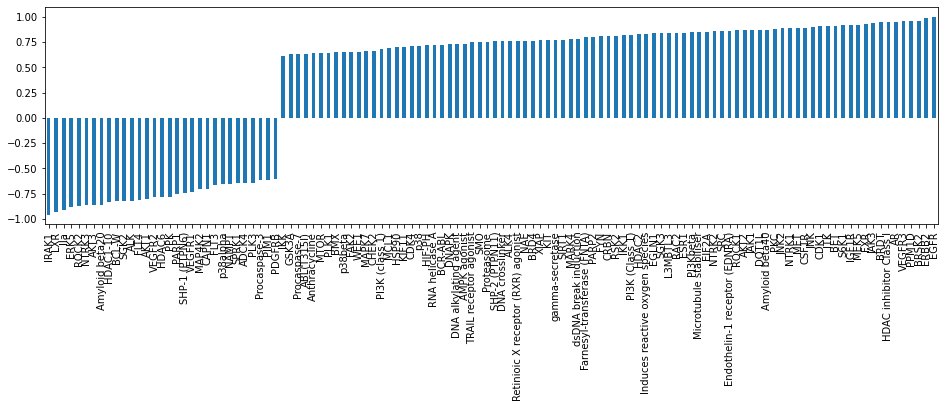

In [ ]:
# Show targets that are functionally similar to others
fig, ax = plt.subplots(figsize=(16, 4));
egfr = df_drug_target_corr['EGFR']
egfr[egfr.abs()>0.6].sort_values().plot.bar(ax=ax);

In [ ]:
egfr.AKT2, egfr.AKT1

(0.8710392152050918, -0.8025990190621156)

In [ ]:
df_interaction.loc['Antimetabolite']

PROGENY_EGFR        0.369600
PROGENY_Hypoxia     0.015162
PROGENY_JAK.STAT   -0.023705
PROGENY_MAPK       -0.380620
PROGENY_NFkB        0.198089
PROGENY_PI3K       -0.061608
PROGENY_TGFb       -0.057319
PROGENY_TNFa       -0.259843
PROGENY_Trail      -0.219321
PROGENY_VEGF       -0.011541
PROGENY_p53        -0.150114
Name: Antimetabolite, dtype: float64

In [ ]:
lymphomas =  df_tissue[df_tissue.tissue=="lymphoma"].index.intersection(df_logIC50.columns)
antimetabolites = df_drug_features[df_drug_features.loc[:, 'Antimetabolite'] == 1].index
df_logIC50.loc[antimetabolites, lymphomas]

,910935,910934,910919,910918,910706,910703,906807,949088,906831,906832,...,1331038,1331039,1331040,1331045,909773,1331048,1331049,1331050,909785,946358
drug,,,,,,,,,,,,,,,,,,,,,
Cytarabine,0.656320,-0.165673,2.506569,NaN,-1.390493,2.573754,-0.583032,-2.181626,2.445943,-1.073316,...,NaN,2.425665,-0.124918,-1.421380,-3.214248,-2.432119,-0.532021,0.681879,-2.039815,2.056958
Methotrexate,-3.172483,-3.692329,-2.147357,NaN,-4.677611,-1.916318,-4.580080,-4.359778,-1.778065,-3.468746,...,NaN,-2.064192,-5.484711,-2.816719,-5.127212,-2.100227,-3.364792,-4.103006,-4.381387,-0.616938


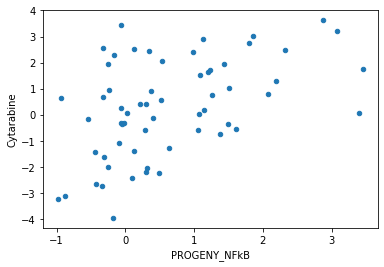

In [ ]:
pd.concat([df_logIC50.loc['Cytarabine', lymphomas].dropna(), df_cell_features.loc[lymphomas, 'PROGENY_NFkB']], axis=1).plot.scatter(x='PROGENY_NFkB', y='Cytarabine')

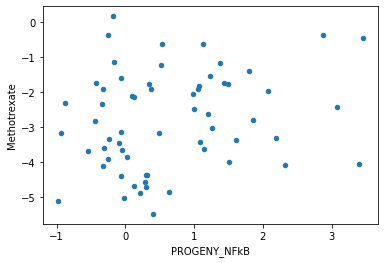

In [ ]:
pd.concat([df_logIC50.loc['Methotrexate', lymphomas].dropna(), df_cell_features.loc[lymphomas, 'PROGENY_NFkB']], axis=1).plot.scatter(x='PROGENY_NFkB', y='Methotrexate')

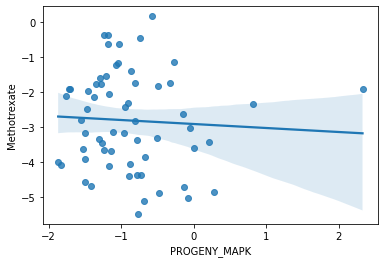

In [ ]:
df_target_pathway = pd.concat([df_logIC50.loc['Methotrexate', lymphomas].dropna(), df_cell_features.loc[lymphomas, 'PROGENY_MAPK']], axis=1)
sns.regplot(data=df_target_pathway, y='Methotrexate', x='PROGENY_MAPK');

In [ ]:
skin =  df_tissue[df_tissue.tissue=="skin"].index.intersection(df_logIC50.columns)
df_interaction

,PROGENY_EGFR,PROGENY_Hypoxia,PROGENY_JAK.STAT,PROGENY_MAPK,PROGENY_NFkB,PROGENY_PI3K,PROGENY_TGFb,PROGENY_TNFa,PROGENY_Trail,PROGENY_VEGF,PROGENY_p53
EGFR,-0.216577,0.028611,-0.043919,0.148301,0.335951,-0.044977,-0.122480,-0.360118,0.086536,0.027399,-0.213195
MTORC1,0.094343,-0.041546,-0.044601,-0.211042,-0.137284,0.054311,-0.094644,-0.038644,-0.046584,0.001982,0.343552
PDGFR,-0.039837,-0.092979,-0.019481,-0.232971,0.185197,0.114313,-0.220969,-0.151905,-0.094623,-0.033935,-0.013108
KIT,-0.049897,0.045549,-0.005191,0.115636,0.060654,-0.055477,0.064629,-0.105257,0.042473,0.014508,-0.031170
VEGFR,0.282194,0.056562,0.021276,-0.158965,-0.014892,-0.077436,0.049050,0.065243,-0.087068,0.004852,-0.142847
...,...,...,...,...,...,...,...,...,...,...,...
TRAIL receptor agonist,-0.084099,0.023077,-0.063249,-0.133727,0.158740,0.030386,-0.053425,-0.259046,0.079905,0.015438,-0.056795
L3MBTL3,-0.027617,-0.000973,-0.006930,-0.044504,0.142331,-0.010815,-0.076458,-0.165727,-0.003543,0.000571,-0.043282
DOT1L,-0.048909,0.009066,-0.026727,-0.043549,0.131039,0.015910,-0.084114,-0.169357,0.007754,0.006432,-0.066923
DNA alkylating agent,-0.019689,-0.012052,-0.007007,-0.036776,0.166741,0.006236,-0.060475,-0.176556,-0.074354,-0.015029,-0.019368


## Crossval

In [ ]:
from sklearn.model_selection import KFold, LeaveOneOut
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [ ]:


# Using cell and drug features, we can validate three
# different settings:
# 1 - Unknown drugs (predict IC50 for unobserved drugs based on their targets)
# 2 - Unknown cells (predict IC50 for unobserved cells based on their pathway activities)
# 3 - Unknown drug and cell (predict IC50 for an unobserved drug/cell combination)
#kf = KFold(n_splits=20, shuffle=True)
#kf = LeaveOneOut()
k = 8
epochs = 200
r2_means = []
r2_cell_splits = []
#splits = MultilabelStratifiedKFold(n_splits=10, shuffle=True).split(df_logIC50, row_features)
splits = KFold(n_splits=10, shuffle=True).split(df_logIC50)
for train_index, test_index in splits:
  print(len(train_index), len(test_index))
  print(df_logIC50.index[test_index])
  # Unknown drugs (remove rows from the training set)
  # We also need to remove the bias for the drugs, as we cannot estimate
  # a bias per drug when we have unknown drugs
  X = df_logIC50.to_numpy()
  X_tr = X[train_index, :]
  FD_tr = row_features[train_index, :]
  params = initialize_weights(X_tr, k=k, row_features=FD_tr)
  params = optimize(X_tr, params, epochs=epochs, loss_options={'row_features': FD_tr, 'reg': 1e-3})
  # Predict for the test set
  X_test = X[test_index, :]
  FD_test = row_features[test_index, :]
  X_hat = mf_with_row_features(params, row_features=FD_test)
  print(loss_mse(X_test, X_hat))
  # For each cell line
  r2_per_cell = []
  for i in range(X_hat.shape[1]):
    x = X_test[:, i]
    xhat = X_hat[:, i]
    not_nan = ~np.isnan(x)
    if np.sum(not_nan) > 2:
      r2, p = pearsonr(x[not_nan], xhat[not_nan])
      r2_per_cell.append(r2)
    else:
      r2_per_cell.append(np.nan)
  print(r2_per_cell)
  r2_cell_splits.append(r2_per_cell)
  r2_means.append(np.nanmean(r2_per_cell))
  print(np.nanmean(r2_per_cell))


230 26
Index(['(5Z)-7-Oxozeaenol', 'AS605240', 'AV-951', 'Axitinib', 'CP724714',
       'Camptothecin', 'Cisplatin', 'EKB-569', 'Etoposide', 'GSK-1904529A',
       'GSK1070916', 'GSK269962A', 'HG-5-113-01', 'KIN001-270', 'Lenalidomide',
       'MG-132', 'OSI-027', 'QL-XI-92', 'Rapamycin', 'Roscovitine',
       'S-Trityl-L-cysteine', 'THZ-2-102-1', 'TL-1-85', 'Temozolomide',
       'XMD15-27', 'Z-LLNle-CHO'],
      dtype='object', name='drug')


  0%|          | 0/200 [00:00<?, ?it/s]

6.292205
[0.522891708496464, 0.4287123705586759, 0.24401095522599386, 0.09345745976618554, 0.5363280618819134, 0.5224748036973085, 0.00944005067296821, 0.5766156737984349, 0.4820387442840513, 0.4578076396022025, 0.5364769039076673, 0.5329488736686003, 0.37619172740392065, 0.5447733551842999, 0.2956926595699337, 0.5233390012217519, -0.10967845034279713, 0.5632951354584015, 0.5447300133316593, -0.23261028221271302, 0.5520077177286897, 0.5709483071074869, 0.44097482740017224, 0.5832032213998347, 0.002258666745849312, 0.3550319098329084, -0.012659460260109293, 0.5080050447461456, 0.3555794281454814, 0.5825169682365059, -0.07500475753301253, 0.5522260269196639, 0.6001126880746043, 0.5299779433356188, 0.507683777235851, 0.5503060591405161, 0.38844811926472406, 0.0002948849258032018, 0.38783233320386856, 0.4831153192489155, 0.35035235980808116, 0.6085211818375771, 0.5312694167339722, 0.3933285854376383, 0.3862555899913386, 0.5119513506975238, 0.344080092296594, 0.0014829972786743412, 0.336029

  0%|          | 0/200 [00:00<?, ?it/s]

8.099529
[0.11132917090709676, 0.33222413048291816, 0.43611368035958853, 0.17771800632819568, 0.4125290605797182, 0.27903466960084905, -0.08318713402995315, 0.2532841500427806, 0.13289294458569811, 0.06690156513215591, 0.2748631747022106, 0.07483146983935651, 0.39417942031523034, 0.2815715716905641, 0.27692422933837024, 0.42376702532644567, -0.13915552094207426, -0.022579908254475093, 0.05332860305774884, -0.02052306706012398, 0.18252091970000583, 0.24996139143214885, 0.3210011211204168, 0.25152052817088777, 0.10777501648908425, 0.09246667319187142, 0.22454013507056442, 0.045388697575654495, 0.12819988075478866, 0.3522266688481473, -0.19512255458525832, 0.25317581833716135, 0.06786179393585431, 0.37626541488727927, 0.044524692775336445, 0.09553569506422853, 0.2584229310977022, 0.23375175875478033, 0.1857300238782583, 0.04237065832503275, 0.05883166755538342, 0.1747516689653467, 0.1777446938238921, 0.32312993557439534, -0.17985288874982513, 0.3093120774949954, 0.29916797198800926, 0.028

  0%|          | 0/200 [00:00<?, ?it/s]

5.2779665
[0.537656245370686, 0.8001742397534435, 0.4855629873982707, 0.5215851881076544, 0.34818100432265564, 0.5101211305271042, 0.8369641708650016, 0.45019910590578527, 0.47749783736575285, 0.3916554800429077, 0.4868958156765198, 0.4081360576497463, 0.5303011230770255, 0.4517869853703517, 0.556240702678997, 0.4000490197185976, 0.4828781593622274, 0.5041394567857366, 0.5956474924229559, 0.4787452322695147, 0.32478506331280177, 0.6538537798424298, 0.4179176350984909, 0.28939006976827586, 0.23267414651286775, 0.5822372301334522, 0.4730902324622479, 0.5739612450039653, 0.09981961146435221, 0.39922091917026437, 0.4051889697875574, 0.5470093749749233, 0.6244082881632751, 0.45917936165922757, 0.44199312456353373, 0.48057662327880857, 0.6363576839996776, 0.5655773536765504, 0.6316773798468849, 0.5922608397820082, 0.6211218383006766, 0.42330476528942634, 0.35799580432326455, 0.38823713510082797, 0.5493137989581962, 0.3808845934120007, 0.35596753813660875, 0.445011355056955, 0.414464308705891

  0%|          | 0/200 [00:00<?, ?it/s]

5.440927
[0.7207624000703737, 0.7536694574204164, 0.808645483525654, 0.5802100887842445, 0.7098937529170102, 0.804471807102314, 0.41088375615864076, 0.7756249959567315, 0.7480214317197069, 0.7075619726530417, 0.7427571827118888, 0.7389384261548074, 0.7039138742244949, 0.7624616166279566, 0.697959120896842, 0.7904682300334832, 0.6514113442278778, 0.7472703904990479, 0.7413950003844197, 0.650155166061493, 0.6973687291852618, 0.7182473681024165, 0.7272263474314592, 0.7251708122205932, 0.6514385455431274, 0.7556455284299889, 0.6414504492134433, 0.6894217830048454, 0.6907902956289124, 0.7633270112041227, 0.6308022708402731, 0.7132818155872841, 0.673027417832725, 0.7620931088779994, 0.7337853465047719, 0.7506966837481437, 0.7482420245358256, 0.6728426848650073, 0.708050026408208, 0.7612473567865828, 0.7259743539700408, 0.7674026850261673, 0.5759824942927252, 0.7694069405521908, 0.7270608171684428, 0.6522627351130176, 0.689864056378079, 0.6254798094606805, 0.5477824269085194, 0.54375746946015

  0%|          | 0/200 [00:00<?, ?it/s]

6.5587907
[0.2243363236412121, 0.187563841737777, 0.13194509600912108, -0.027527488334168994, 0.21569430683942803, 0.3546692294089382, -0.11053637910533863, 0.12779776069304882, 0.1313691860679869, -0.0332727100951759, 0.128318122757228, -0.03114475271753612, 0.25649255039806185, -0.05731808740429036, 0.13996161432224133, 0.09538199276579097, 0.0751906552323597, -0.03775825211515341, 0.030999959603917434, 0.04094212610210942, -0.1775268005365453, 0.05519913195051614, 0.07399274690873804, 0.19909218001388806, 0.021737878216312418, 0.13114891772465584, 0.049100333467198894, -0.05104172028111919, 0.5278733587654144, 0.2450126525158957, -0.14133970865654166, -0.010523012563882666, 0.19798973864646477, 0.09001063958609819, -0.1116637475433354, 0.03504202270424623, 0.05392286111921935, 0.09675713381656721, -0.04206836304882783, -0.03062678079577832, 0.08758937411086978, 0.11501600302737951, 0.3384324577254687, 0.19486187419086556, -0.04018620648339453, 0.26549045641635544, -0.054045365032126

  0%|          | 0/200 [00:00<?, ?it/s]

5.048175
[0.6613243457070768, 0.6086286144818839, 0.6667505410372935, 0.524478695226784, 0.773499951985543, 0.6864085743130683, 0.30942974156462294, 0.7940655698944754, 0.6884337439674154, 0.7207971512462172, 0.7141197236929197, 0.65248301713149, 0.8068182614591574, 0.6365029431283825, 0.61352380440459, 0.6337381994472546, 0.1815607490740449, 0.6362987627003153, 0.6309348958297265, 0.19973814503860307, 0.6233699732505438, 0.7345540729265589, 0.7826084698773904, 0.6366799959659797, 0.17159462739487286, 0.7235338173159468, 0.6317626638037871, 0.666072788148226, 0.5001563810364148, 0.7753024283577673, 0.039245421436769574, 0.639961713165593, 0.7004394577259672, 0.6929447634246871, 0.6247433014523903, 0.6428899259011025, 0.7162759712364155, 0.543835147214553, 0.7550982812958148, 0.7597231300099848, 0.792642444808026, 0.7418875745316643, 0.619140529005645, 0.7185820374903251, 0.7497980035854234, 0.7427847560612685, 0.7361401770182399, 0.19960068609239895, 0.7575255555507356, 0.6706772399107

  0%|          | 0/200 [00:00<?, ?it/s]

9.135886
[0.5339341637326702, 0.5975407308299306, 0.5233654417108156, 0.5774776237649049, 0.6838972579623281, 0.5842635710936368, 0.6654553673262534, 0.6636396492270454, 0.6166741110145305, 0.5545910733147731, 0.641972842834237, 0.6666437141658592, 0.44304988685103436, 0.6038950804228378, 0.5522422789152949, 0.6408873868230154, 0.5047288642881078, 0.6868210556115933, 0.6749442412158776, 0.6471632558918847, 0.6023433267160042, 0.5557835538950556, 0.6033637217975236, 0.7605508371268502, 0.692768989688625, 0.4935924189645477, 0.5864603379629748, 0.608372023160414, 0.4055284663025745, 0.6590487485620076, 0.4965926866619379, 0.5884587334823239, 0.6013831685824905, 0.5603722600394291, 0.6157121237991877, 0.4773878342716384, 0.49782767542394907, 0.5219278053650928, 0.5094980842123131, 0.6860374709476966, 0.2682425488788955, 0.5035330355028381, 0.5186271467533274, 0.6683691517487161, 0.1599892625768556, 0.20379056666149123, 0.35656599490667085, 0.7208350927217684, -0.11787044525794103, 0.57837

  0%|          | 0/200 [00:00<?, ?it/s]

7.623626
[0.45707764535704626, 0.48755830203058076, 0.530561569659023, 0.47407394533526687, 0.6285766671726879, 0.7150698530992566, 0.7866324342248047, 0.6618464602883485, 0.6262233446482776, 0.668549288746433, 0.6683526290386957, 0.6990336685111832, 0.6583438914405451, 0.7261135374942821, 0.6476635410358808, 0.7640821006873488, 0.748059994747835, 0.5795186308877945, 0.6997519580288802, 0.7118426825257633, 0.684819615087867, 0.49717913965975813, 0.7550876613032497, 0.6104680229928309, 0.7773382163260678, 0.3522052335007104, 0.6731439384963839, 0.6797641921325712, 0.4534326266981153, 0.6467707437727916, 0.7508163166123816, 0.6360246368619, 0.6443103227994292, 0.7761860334177064, 0.5636888590458221, 0.45119918965684075, 0.6802398085349969, 0.506337330859634, 0.5634351366144815, 0.7895274749842517, 0.46258394260891783, 0.6728624309366283, 0.5429545384647617, 0.579222605202762, 0.24236198044556162, 0.2369727724336504, 0.4758647223935397, 0.6791168571357502, 0.3260481248371158, 0.4561649885

  0%|          | 0/200 [00:00<?, ?it/s]

4.4658084
[0.09950705550098042, 0.2790172511023661, 0.6245297707865785, 0.4081616996289344, 0.34806223978851947, 0.5147320745981073, 0.026162630671132243, 0.3625600078234936, 0.3009318182429731, 0.4063270495564398, 0.28306040538911914, 0.43016502592176803, 0.45219400968065665, 0.37760181613460697, 0.41479282882506396, 0.4199683279370001, 0.1570120335621155, 0.27674870884517044, 0.305445124514412, 0.31806599646871886, 0.3233427803824227, 0.3369653880494412, 0.5718670630782862, 0.35085886454903015, 0.2809513008517173, 0.16360293460879508, 0.43959893447410203, 0.2756140774154411, 0.2089673531686531, 0.4843362455837537, 0.4004956523651065, 0.32179074209861624, 0.3766892789487029, 0.5171633198045053, 0.1112758470223941, 0.16293457702803896, 0.44413325410841403, 0.4907211405547386, 0.3117037149174726, 0.12274761227262546, 0.3824290157349489, 0.21437904491910437, 0.3036988932552747, 0.38106212079913915, 0.4623422693744149, 0.47623906130010724, 0.6158962534083752, 0.0820958448173543, 0.2154231

  0%|          | 0/200 [00:00<?, ?it/s]

4.898255
[0.4953647176973208, 0.5175046230694337, 0.5709816336197074, 0.5529339559667876, 0.5032489762166306, 0.590300924555591, 0.5218471057743994, 0.5951275342359905, 0.5746903937485021, 0.5817746360399989, 0.5251207009112403, 0.5629343354835502, 0.5610413731111102, 0.5209758483127971, 0.5964372843305892, 0.47790671247032845, 0.6334235105069206, 0.45083734832767436, 0.5475699417738257, 0.5102297865251548, 0.3099636021002443, 0.5206471201926863, 0.42170775175121405, 0.5046319607339304, 0.4548466156694623, 0.5622927152937287, 0.610580692048845, 0.5606828499680656, 0.4010410151021884, 0.4655600773563671, 0.630093309260971, 0.587961924178956, 0.5062289392523118, 0.5059345649084283, 0.48954278442561555, 0.3128087599290395, 0.4917007491694617, 0.5252747498776471, 0.6532647013838195, 0.6384006253191267, 0.6003798672867474, 0.5317255718720677, 0.4111176224574342, 0.634110980504951, 0.4281339984482849, 0.3616192459078847, 0.4918938732194137, 0.5121110241120821, 0.5286727442177297, 0.304370108

In [ ]:
np.mean(r2_means)

0.4221309179812339

In [ ]:
df_crossval = pd.DataFrame(r2_cell_splits, columns=df_logIC50.columns)
df_crossval

cell,906794,753531,753532,753535,1290724,1240121,1290725,1240122,753538,910916,753541,906837,910936,906863,1240140,907059,924111,753561,753562,907061,907062,1240161,1240162,1298215,753570,753583,1298362,1240196,1240204,1298529,1240205,1298531,1240206,1240207,909700,909708,1299050,910911,910701,910904,...,688015,724872,1299062,946372,924189,946363,908118,1240125,949092,1240149,1298167,949154,930082,906825,1479987,1479988,1298156,1299052,1330948,1659819,1659817,1290767,1290768,1298157,1290771,713869,1298160,1299061,1330960,909762,1330981,908120,1303911,1240224,905943,1298144,930301,1480367,1299069,1298218
0,0.522892,0.428712,0.244011,0.093457,0.536328,0.522475,0.009440,0.576616,0.482039,0.457808,0.536477,0.532949,0.376192,0.544773,0.295693,0.523339,-0.109678,0.563295,0.544730,-0.232610,0.552008,0.570948,0.440975,0.583203,0.002259,0.355032,-0.012659,0.508005,0.355579,0.582517,-0.075005,0.552226,0.600113,0.529978,0.507684,0.550306,0.388448,0.000295,0.387832,0.483115,...,0.032771,0.352085,0.361060,0.507069,0.969777,-0.003565,0.655396,0.678756,NaN,0.414005,0.557583,0.478177,0.282883,0.222045,0.545171,0.515099,0.709817,0.652192,0.666907,0.259416,0.499779,0.290991,0.376557,0.552329,0.508404,0.407239,0.231979,0.489170,0.249224,0.070790,0.422299,0.491059,0.480638,0.630037,0.458673,0.335330,0.258739,0.383534,0.460467,0.380294
1,0.111329,0.332224,0.436114,0.177718,0.412529,0.279035,-0.083187,0.253284,0.132893,0.066902,0.274863,0.074831,0.394179,0.281572,0.276924,0.423767,-0.139156,-0.022580,0.053329,-0.020523,0.182521,0.249961,0.321001,0.251521,0.107775,0.092467,0.224540,0.045389,0.128200,0.352227,-0.195123,0.253176,0.067862,0.376265,0.044525,0.095536,0.258423,0.233752,0.185730,0.042371,...,-0.153608,0.192303,0.063555,0.136777,NaN,-0.003386,-0.120892,0.339011,NaN,0.182798,0.096059,0.040130,0.224805,-0.134863,0.572637,0.427552,0.176461,0.012688,0.170609,0.385665,-0.058608,0.276982,0.074262,0.050697,0.345573,0.107248,0.332353,-0.062003,0.323497,-0.098677,0.145378,0.195471,0.099784,-0.198831,0.190469,0.241678,-0.186438,0.378754,0.213615,0.355620
2,0.537656,0.800174,0.485563,0.521585,0.348181,0.510121,0.836964,0.450199,0.477498,0.391655,0.486896,0.408136,0.530301,0.451787,0.556241,0.400049,0.482878,0.504139,0.595647,0.478745,0.324785,0.653854,0.417918,0.289390,0.232674,0.582237,0.473090,0.573961,0.099820,0.399221,0.405189,0.547009,0.624408,0.459179,0.441993,0.480577,0.636358,0.565577,0.631677,0.592261,...,0.741722,0.658551,0.516504,0.437392,NaN,0.851431,0.403121,0.461386,NaN,0.522313,0.618746,0.625465,0.539043,0.853390,0.175062,0.338248,0.327957,0.223076,0.464996,0.392778,0.466632,0.414008,0.221922,0.324779,0.570334,0.254814,0.349455,0.360001,0.741480,0.804835,0.774345,0.450391,0.873608,0.532685,0.538735,0.323747,0.564212,0.499890,0.286466,0.627568
3,0.720762,0.753669,0.808645,0.580210,0.709894,0.804472,0.410884,0.775625,0.748021,0.707562,0.742757,0.738938,0.703914,0.762462,0.697959,0.790468,0.651411,0.747270,0.741395,0.650155,0.697369,0.718247,0.727226,0.725171,0.651439,0.755646,0.641450,0.689422,0.690790,0.763327,0.630802,0.713282,0.673027,0.762093,0.733785,0.750697,0.748242,0.672843,0.708050,0.761247,...,0.446682,0.682081,0.706487,0.766819,NaN,0.357711,0.706544,0.741489,NaN,0.683731,0.681603,0.768871,0.772370,0.442174,0.794048,0.714794,0.903724,0.776279,0.758487,0.777018,0.595976,0.767409,0.747627,0.738939,0.977609,0.910227,0.719814,0.873749,0.539024,0.528833,0.275570,0.681551,0.464810,0.521712,0.678848,0.728867,0.710139,0.756876,0.621160,0.711669
4,0.224336,0.187564,0.131945,-0.027527,0.215694,0.354669,-0.110536,0.127798,0.131369,-0.033273,0.128318,-0.031145,0.256493,-0.057318,0.139962,0.095382,0.075191,-0.037758,0.031000,0.040942,-0.177527,0.055199,0.073993,0.199092,0.021738,0.131149,0.049100,-0.051042,0.527873,0.245013,-0.141340,-0.010523,0.197990,0.090011,-0.111664,0.035042,0.053923,0.096757,-0.042068,-0.030627,...,0.092496,0.220131,-0.149385,-0.189109,0.813556,0.198658,0.062913,0.316159,0.930687,0.053382,0.121156,0.074933,-0.066207,-0

In [ ]:
df_tissue

,tissue
CosmicID,
906800,leukemia
687452,Bladder
1287381,lung_NSCLC
924100,prostate
910924,stomach
...,...
998206,lymphoma
1330945,leukemia
1298355,lung_SCLC


In [ ]:
df_crossval.T.join(df_tissue).dropna().reset_index()

,cell,0,1,2,3,4,5,6,7,8,9,tissue
0,906794,0.522892,0.111329,0.537656,0.720762,0.224336,0.661324,0.533934,0.457078,0.099507,0.495365,aero_dig_tract
1,753531,0.428712,0.332224,0.800174,0.753669,0.187564,0.608629,0.597541,0.487558,0.279017,0.517505,aero_dig_tract
2,753532,0.244011,0.436114,0.485563,0.808645,0.131945,0.666751,0.523365,0.530562,0.624530,0.570982,aero_dig_tract
3,753535,0.093457,0.177718,0.521585,0.580210,-0.027527,0.524479,0.577478,0.474074,0.408162,0.552934,aero_dig_tract
4,1290724,0.536328,0.412529,0.348181,0.709894,0.215694,0.773500,0.683897,0.628577,0.348062,0.503249,aero_dig_tract
...,...,...,...,...,...,...,...,...,...,...,...,...
961,1240224,0.630037,-0.198831,0.532685,0.521712,0.251048,0.467103,0.718814,0.798416,0.074698,0.399620,kidney
962,905943,0.458673,0.190469,0.538735,0.678848,0.174891,0.480915,0.794737,0.565129,0.486215,0.399453,lung_NSCLC
963,1298144,0.335330,0.241678,0.323747,0.728867,0.021313,0.664164,0.642431,0.655467,0.387255,0.611232,skin
964,930301,0.258739,-0.186438,0.564212,0.710139,-0.000740,0.594388,0.521813,0.645564,0.224638,0.453571,skin


In [ ]:
df_crossval_tissue = df_crossval.T.join(df_tissue).dropna().reset_index().drop('cell', axis=1).melt(id_vars='tissue')
df_crossval_tissue

,tissue,variable,value
0,aero_dig_tract,0,0.522892
1,aero_dig_tract,0,0.428712
2,aero_dig_tract,0,0.244011
3,aero_dig_tract,0,0.093457
4,aero_dig_tract,0,0.536328
...,...,...,...
9655,kidney,9,0.399620
9656,lung_NSCLC,9,0.399453
9657,skin,9,0.611232
9658,skin,9,0.453571


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 11.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 12.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 8.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 25.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 6.3% of the points cannot be placed; you

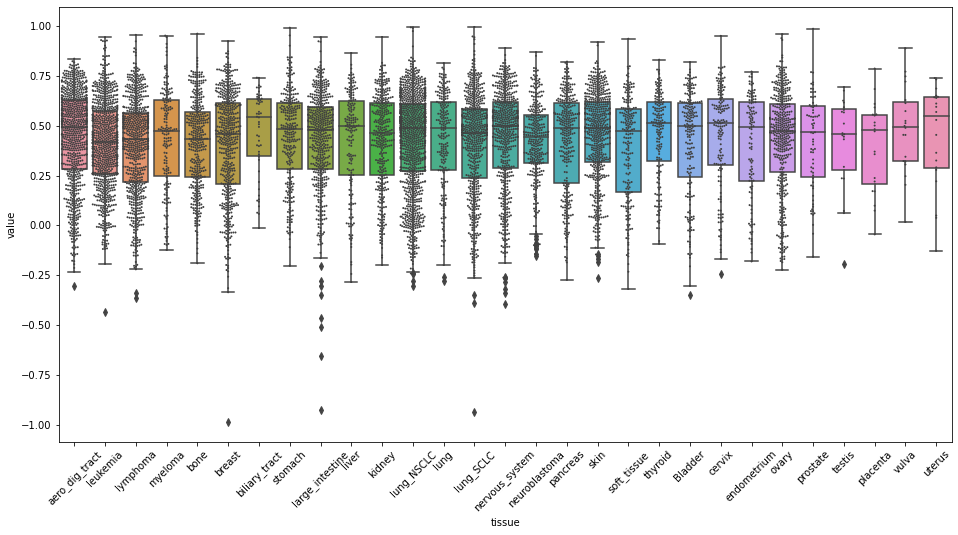

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(data=df_crossval_tissue, x='tissue', y='value', ax=ax)
ax = sns.swarmplot(x="tissue", y="value", data=df_crossval_tissue, color=".25", size=2)
plt.xticks(rotation=45);

In [ ]:
# Using cell and drug features, we can validate three
# different settings:
# 1 - Unknown drugs (predict IC50 for unobserved drugs based on their targets)
# 2 - Unknown cells (predict IC50 for unobserved cells based on their pathway activities)
# 3 - Unknown drug and cell (predict IC50 for an unobserved drug/cell combination)
#kf = KFold(n_splits=20, shuffle=True)
#kf = LeaveOneOut()
k = 8
epochs = 1000
r2_means = []
r2_cell_splits = []
#splits = MultilabelStratifiedKFold(n_splits=10, shuffle=True).split(df_logIC50, row_features)
splits = KFold(n_splits=10, shuffle=True).split(df_logIC50.T)
for train_index, test_index in splits:
  train_cells = df_logIC50.columns[train_index]
  test_cells = df_logIC50.columns[test_index]
  print(len(train_index), len(test_index))
  # Unknown cells (remove rows from the training set)
  X_tr = df_logIC50.loc[:, train_cells].to_numpy()
  X_test = df_logIC50.loc[:, test_cells].to_numpy()
  FD_tr = df_cell_features.loc[df_logIC50.columns[train_index]].to_numpy()
  FD_test = df_cell_features.loc[df_logIC50.columns[test_index]].to_numpy()

  params = initialize_weights(X_tr, k=k, col_features=FD_tr)
  params = optimize(X_tr, params, epochs=400,
                  opt=optimizers.adam(0.10),
                  loss_options={'col_features': FD_tr, 'reg': 1e-4})

  # Predict for the test set
  X_hat = mf_with_col_features(params, col_features=FD_test)
  print(loss_mse(X_test, X_hat))

  # For each drug
  r2_per_sample = []
  for i in range(X_hat.shape[0]):
    x = X_test[i, :]
    xhat = X_hat[i, :]
    not_nan = ~np.isnan(x)
    if np.sum(not_nan) > 2:
      r2, p = pearsonr(x[not_nan], xhat[not_nan])
      r2_per_sample.append(r2)
    else:
      r2_per_sample.append(np.nan)
  print(r2_per_sample)
  r2_cell_splits.append(r2_per_sample)
  r2_means.append(np.nanmean(r2_per_sample))
  print(np.nanmean(r2_per_sample))

891 99


  0%|          | 0/400 [00:00<?, ?it/s]

1.9301264
[0.4433531939973091, 0.4375826838116643, 0.42593296668454106, 0.1765095885247146, 0.03916468145230406, 0.32079179371736627, 0.4405751640455022, 0.37107456178725656, 0.30773244322101634, 0.4989529116170801, 0.24047488710358758, 0.42462089449699214, 0.17363815973092875, 0.10719599626885389, 0.5608995724801206, 0.4645452750926519, 0.20232637482510465, 0.3598421407058049, 0.38543580537865413, 0.3438589423478969, 0.27095447441190745, 0.4835306753130725, 0.4889181798417939, 0.39407329307578043, 0.2631481568960437, 0.43723093941642577, 0.467368581286665, 0.43311894038592363, 0.4271795669399832, 0.3798239106111709, 0.33730940349477256, 0.2618940519412009, 0.35915709019459596, 0.10568935056107365, -0.0251187657432078, 0.6030081145139125, 0.3385337278719939, 0.455648849077889, 0.0008517773698634898, -0.033451080632591154, 0.31445986355159405, 0.1844831704212548, 0.34541904739474105, 0.5160707929724395, 0.1599536519959253, 0.2828354809246482, 0.08736321371862919, 0.4515339906761358, 0.1

  0%|          | 0/400 [00:00<?, ?it/s]

1.9896164
[0.44390433016920616, 0.3665773944905509, 0.36634167691432606, 0.2894358913336883, 0.4212926220676799, 0.5743872761149794, 0.36437168173827694, 0.21130070300508172, 0.45796801619369865, 0.35222519096782795, 0.1994412452208924, 0.4304435084823859, 0.11118498409525635, 0.03160184075576516, 0.3617793168156764, 0.48566194420003905, 0.297467377497734, 0.3868648449595204, 0.39805555028610495, 0.42841292602929154, 0.3030962904682474, 0.3699296769730171, 0.5096921099543638, 0.23419052459496734, 0.16413194093964767, 0.484045154399561, 0.3487539707979629, 0.30624772478056833, 0.4175802544893224, 0.2726643880816622, 0.3613243909873229, 0.21562523128205763, 0.41668264532606614, 0.33477997562760453, -0.08467974026311544, 0.5158696210688271, 0.2857896046755305, 0.3524464310311376, 0.2729759484831419, -0.07443025572188239, 0.15561009201647738, -0.02598730249693821, 0.2663561233008935, 0.4551251410510186, 0.1947764045495256, 0.16993883064770918, 0.28985617167086447, 0.4227053507563796, 0.041

  0%|          | 0/400 [00:00<?, ?it/s]

1.7027042
[0.41519166786649453, 0.4022988340755646, 0.4342765261961505, 0.2601161239813254, 0.1862284994087613, 0.34910320568776365, 0.6281649748555261, 0.3843148854880552, 0.3635701307653843, 0.48013202889980394, 0.21317502242692205, 0.4317096757860119, 0.13014135110408603, 0.2752961033785437, 0.4587532345548186, 0.5339108407746476, 0.23152904857675985, 0.5205989378258882, 0.5982730719414414, 0.3658195483888812, 0.35484313136056, 0.5725544271864115, 0.516140214574657, 0.12434169689619745, 0.3588199003828605, 0.44546482007508037, 0.28344127076015585, 0.36441516566664084, 0.3391178705716615, 0.17996416041785882, 0.08518759463254262, 0.43913867267457546, 0.3872900079773058, 0.32328584885986206, 0.24204902965551628, 0.6041131608173801, 0.3531649639953837, 0.5508075772092508, 0.18870107601822075, 0.09426448123809314, 0.3837879822625135, 0.22384110583784117, 0.28179514261067345, 0.6447250825994371, 0.3181303444541753, 0.35339193384357787, 0.07097771960935437, 0.43157096223367714, 0.30771393

  0%|          | 0/400 [00:00<?, ?it/s]

1.6302408
[0.2838184377521841, 0.4812422458234295, 0.49784386502715505, 0.11129885321081176, 0.4689744520088243, 0.36183366818919055, 0.4811697524396695, 0.3129630683440337, 0.354296810781546, 0.5330478140748556, 0.12162891888764103, 0.32483540908930836, 0.16941721944451713, 0.11821995709990918, 0.4556877846885989, 0.47302048799456264, 0.11108617059343089, 0.26046156144792354, 0.45746795103874976, 0.36346570751035034, 0.19597411884203686, 0.4833650431796648, 0.6882162428243505, 0.06555488433835586, -0.015253080214260162, 0.5497612935962648, 0.4128387253601128, 0.2799709974709947, 0.46539493540755283, 0.2835715605185018, 0.23894518620421068, 0.26700992267227586, 0.33940998243196396, 0.31331481967712066, -0.04504195541463026, 0.5143869178240044, 0.027777207872233797, 0.440838149144152, 0.04843280559815844, 0.09963604603480182, 0.294313421405691, -0.06359824989473499, 0.4255899499242414, 0.5078973136609599, 0.3361665094105324, 0.36599313259575694, 0.1764009505534396, 0.21294149179733415, 

  0%|          | 0/400 [00:00<?, ?it/s]

1.8445556
[0.49440096646763415, 0.36895565557854404, 0.502776902515831, 0.07717276332651091, 0.0735272365950413, 0.30593115744346894, 0.5221520420013669, 0.43439569106280645, 0.23164636522454274, 0.5072689500183544, 0.23181909980351367, 0.3272411809272275, 0.16051845342913784, 0.2570763007967555, 0.31207845727685296, 0.4027106378685131, 0.24222127313011863, 0.4746300637064977, 0.48028741291203925, 0.4189509659205613, 0.3216769530513142, 0.36622359752147476, 0.5927193700968623, 0.2574246277380735, 0.234474696650382, 0.5390205672926297, 0.3081392212473435, 0.4556790287225786, 0.23192259793896997, 0.30535073191158213, 0.348924510437819, 0.26636220399234517, 0.35323993740944043, 0.29819095093763354, 0.18008989993363644, 0.5572725124623451, 0.07068419270614483, 0.47647057714857516, 0.13102640371908356, 0.19312316917221875, 0.2256422745522252, 0.08532924224248735, 0.44425414789314205, 0.6431221792991744, 0.2207573544312631, 0.24971487770583367, 0.25489795124522024, 0.3639517895599462, -0.000

  0%|          | 0/400 [00:00<?, ?it/s]

1.8641117
[0.43590948548262887, 0.46765823738762347, 0.16820664198062282, -0.035776083731732244, 0.07225200538116319, 0.38313008950917155, 0.39443028911087163, -0.0027667576848499557, 0.28136183923143127, 0.22707626151851604, -0.028426779735384378, 0.29847623779293925, -0.058176927919658124, 0.04626559484683959, 0.333689082964189, 0.0413034423212235, 0.06470763862841541, 0.1436630521234363, 0.15304443963090592, 0.339593953465731, -0.007878511626442371, 0.35620249193052034, 0.5139503642738364, 0.16535692268790225, 0.06819436189449761, 0.4093945479674768, 0.31341083537428344, 0.3628586031722868, 0.2785698278995322, 0.3709843866012463, 0.37054473445980135, 0.19543542825918814, 0.1118463438265331, 0.04696130965549668, 0.032924340201202454, 0.23692758644501036, 0.1553126201378179, 0.18923786446462956, 0.06795120424095377, 0.14603183990489388, 0.23509138361585022, 0.16405258470516376, 0.07558709936976052, 0.2224276680763112, 0.1531581704957656, 0.07631211913885308, 0.1378415348054347, 0.4146

  0%|          | 0/400 [00:00<?, ?it/s]

1.7662348
[0.4226366133547445, 0.4780803960405707, 0.41274458961775784, 0.243314663659543, 0.1699628912422417, 0.5484235252217956, 0.4630535338437576, 0.14714309293044103, 0.34957973939601916, 0.3786446512004353, 0.24576527259748404, 0.38077404231464146, 0.06725925419977465, 0.16731073708591718, 0.3837846688263421, 0.3107739923608228, 0.12847920969061546, 0.507854431130397, 0.37991127526149876, 0.14286018213998308, 0.3395590967679774, 0.48095266520176305, 0.6652605637629005, 0.4222819578501754, 0.15146482507223602, 0.592307100301962, 0.35996972308901276, 0.31110428108958593, 0.3644607067216127, 0.3251626291663456, 0.3011117231118246, 0.25629612012518016, 0.27792416051651486, 0.0630478619279239, 0.11680890683531837, 0.4583492413853212, 0.12955436530257564, 0.41500734965938474, 0.26482963178830415, -0.010702968906907445, 0.23979643909489787, 0.07425035722945, 0.2894031514571833, 0.45645041509797873, 0.22046851153160238, 0.29461004182388567, 0.36940160560464946, 0.35555786507510295, 0.298

  0%|          | 0/400 [00:00<?, ?it/s]

1.9178118
[0.3864376602743119, 0.4207140880485726, 0.2915510933875627, 0.06889699112557243, 0.011526838028291186, 0.2244854174485862, 0.4796159577516441, 0.3543593824110643, 0.22552171315797442, 0.33142502457829814, 0.06482724964833331, 0.4005822739199064, 0.15484563009586522, 0.1395865296973047, 0.4524397275590865, 0.328092163277008, 0.30458859155134876, 0.3477471595241216, 0.25439197645129036, 0.3426950017046066, 0.19639510376067168, 0.3161553778579207, 0.4547531944673927, 0.3010982287975412, 0.14507750304385114, 0.5132743435096853, 0.2741857010082587, 0.39150862851192364, 0.17930323123248904, 0.2279614324693303, 0.18655646371147783, 0.37661422207652656, 0.06726466931099152, 0.05435204783193161, 0.1595580623523236, 0.34875532413942617, 0.17625982682558622, 0.29848623204833086, -0.028671334045619376, 0.0746541119166819, 0.11402585768093783, 0.10673014868314899, 0.3557484404752722, 0.3985401050391597, 0.19687748609088104, 0.16624371887604014, 0.24259108921687372, 0.23512246991240582, 0

  0%|          | 0/400 [00:00<?, ?it/s]

1.8822169
[0.2685505264131737, 0.4587134405603769, 0.3857977420707193, 0.12010163621423209, 0.2463763123741671, 0.21421189128774842, 0.5379123488573572, 0.5187408769082517, 0.2723325798225695, 0.4925642886808493, 0.12026267113828792, 0.33363305636815216, 0.027398029490985944, 0.35458337560305475, 0.3359036118506472, 0.2511297069988189, 0.11593649892591695, 0.3271174087100678, 0.3157970846870699, 0.4651253966387746, 0.14112194560823801, 0.382584065449631, 0.39934195259020283, 0.024912364297040888, 0.0072041931196027776, 0.45468997046562826, 0.29170207769452616, 0.3748574180044743, 0.21980251376717855, 0.21895839852207197, 0.2518902511139561, 0.23698195529874247, 0.21060627832067405, 0.29616046831181786, 0.11905909342816079, 0.48912101101333133, 0.10784921820995441, 0.30606255874205873, 0.034952536061220646, 0.08820204196826581, 0.07328494749141072, 0.2412323435251355, 0.23444741899557903, 0.3559555413367186, 0.00762131758901591, 0.3914701256787464, 0.21943907852226535, 0.303474703556297

  0%|          | 0/400 [00:00<?, ?it/s]

1.792261
[0.5172550173836796, 0.30870617893116914, 0.5063074492082867, 0.3946228467380879, 0.02744946351928304, 0.26186189890333095, 0.28206426894961567, 0.47995709616033866, 0.319710832032127, 0.40714467894566203, 0.029070531160526818, 0.25816067453703123, 0.12093310061461511, 0.09341498331575648, 0.2913565135667773, 0.37928527834253456, 0.10086295588625635, 0.3850391309679735, 0.48742533949676614, 0.35450322693873537, 0.20283989896886748, 0.3591088108753869, 0.5614383946513636, 0.03736167337497408, 0.25900373193601084, 0.6232714120082846, 0.22560641088632372, 0.38545268385036074, 0.2784750024761708, 0.272588256468978, 0.4330618227767172, 0.24590416840408977, 0.31787678377405193, 0.04596826857435538, 0.0953427156616605, 0.5425643207029511, 0.09129579001415757, 0.521347029648416, 0.2761200730653983, 0.0793139597569211, 0.2498872111570933, -0.03967234798525119, 0.337784073214142, 0.5842064622024848, 0.2625236897963303, 0.11913199563212672, 0.27396817329689266, 0.2644297508826669, 0.4204

## Drug synergism

See https://www.nature.com/articles/s41540-020-0136-x